# 1. Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns

In [2]:
import re
import string

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import xgboost
from xgboost import XGBClassifier

In [8]:
# create empty list at beginning of every jupyter notebook
hyperparameter_table  = []

# 2. Load Datasets

In [9]:
# load dataset
news = pd.read_csv('../Data/news_classification_Feb06_24.csv', index_col=0, parse_dates=['date', 'election_day'])
news.head()

,title,text,subject,date,label,char_count_text,word_count_text,avg_word_length_text,char_count_title,word_count_title,avg_word_length_title,year,month,day,day_of_week,election_day,days_to_election
22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,2017-02-13,fake_news,1028,171,6.011696,89,14,6.357143,2017,2,13,0,2016-11-08,97
27917,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,2017-04-05,real_news,4820,771,6.251621,55,8,6.875000,2017,4,5,2,2016-11-08,148
25007,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,2017-09-27,real_news,1848,304,6.078947,64,10,6.400000,2017,9,27,2,2016-11-08,323
1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,2017-05-22,fake_news,1244,183,6.797814,89,12,7.416667,2017,5,22,0,2016-11-08,195
32476,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,2016-06-24,real_news,3137,529,5.930057,55,10,5.500000,2016,6,24,4,2016-11-08,-137


In [10]:
# check shape, rows and columns
news.shape

(37924, 17)

In [11]:
# check column names
news.columns

Index(['title', 'text', 'subject', 'date', 'label', 'char_count_text',
       'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'month', 'day',
       'day_of_week', 'election_day', 'days_to_election'],
      dtype='object')

In [12]:
news['month'] = news['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',\
                                  7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})
news['day_of_week'] = news['day_of_week'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',\
                                               5:'Saturday', 6:'Sunday'})

In [13]:
news['label'] = news['label'].map({"real_news":0, "fake_news":1})

In [14]:
# remove news sources, especially locations and reuters
news['text'] = news['text'].apply(lambda x: x.split('-', 1)[1].strip()\
                                        if 'Reuters' in x and '-' in x and len(x.split('-')) > 1 else x)
# remove all reuters
news['text'] = news['text'].str.replace(r'Reuters|reuters|REUTERS', '', regex=True)

In [15]:
def remove_last_sentence(text):
        sentences = nltk.sent_tokenize(text)
        sentence = sentences[:-1] if sentences else ""
        return ''.join(sentence)

# remove news note, which is always last sentence.
news['text'] = news['text'].apply(remove_last_sentence)

In [16]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37924 entries, 22216 to 28254
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  37924 non-null  object        
 1   text                   37924 non-null  object        
 2   subject                37924 non-null  object        
 3   date                   37924 non-null  datetime64[ns]
 4   label                  37924 non-null  int64         
 5   char_count_text        37924 non-null  int64         
 6   word_count_text        37924 non-null  int64         
 7   avg_word_length_text   37924 non-null  float64       
 8   char_count_title       37924 non-null  int64         
 9   word_count_title       37924 non-null  int64         
 10  avg_word_length_title  37924 non-null  float64       
 11  year                   37924 non-null  int64         
 12  month                  37924 non-null  object        
 13  da

# 3. Data Preprocessing and Modeling
**Two methods will be used for modeling:**

**The method 1 use features new created including character count, word count, average word length in title and text, year, month, day, day of week and days to election.**

**The method 2 use only the text column and vectorize with CountVectorizer() or TfidfVectorizer() with different parameters like ngram_range, max_df and min_df.**

## 3.1 Data Preparation

In [17]:
X = news[['text', 'char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'month', 'day', 'day_of_week', 'days_to_election']]
y = news.label

In [18]:
# Create training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# check shapes
X_train.shape, X_val.shape

((30339, 12), (7585, 12))

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30339 entries, 40274 to 42397
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   text                   30339 non-null  object 
 1   char_count_text        30339 non-null  int64  
 2   word_count_text        30339 non-null  int64  
 3   avg_word_length_text   30339 non-null  float64
 4   char_count_title       30339 non-null  int64  
 5   word_count_title       30339 non-null  int64  
 6   avg_word_length_title  30339 non-null  float64
 7   year                   30339 non-null  int64  
 8   month                  30339 non-null  object 
 9   day                    30339 non-null  int64  
 10  day_of_week            30339 non-null  object 
 11  days_to_election       30339 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 3.0+ MB


In [21]:
# 1. Define which columns should be processed in which way
numeric_features = ['char_count_text','word_count_text', 'avg_word_length_text',
                    'char_count_title','word_count_title','avg_word_length_title',
                    'year','day','days_to_election']

categorical_features = ['month', 'day_of_week']

# This is our text feature
text_feature = 'text'


# 2. Create the preprocessing pipelines for each data type
# Pipeline for numeric features: Scale them!
numeric_transformer = StandardScaler()

# Pipeline for categorical features: One-hot encode them
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Pipeline for text features: Vectorize using TF-IDF
# We add a few common parameters for better performance
text_transformer = CountVectorizer(
    stop_words='english')


# 3. Combine preprocessing steps into a single transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('count', text_transformer, text_feature)
    ],
    remainder='drop' # Drop any columns we haven't specified
)

## 3.2 Modeling

### 3.2.1 Method_1 Exp_1 Logistic Regression

In [22]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [23]:
# 1. Create the full pipeline by chaining the preprocessor and the classifier
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# 2. Train the entire pipeline on the training data
lr_pipeline.fit(X_train, y_train)

# 3. Evaluate the model
# (No need for cross-validation on the training set for this example, we'll use the validation set)
y_val_pred = lr_pipeline.predict(X_val)

In [24]:
train_accuracy = lr_pipeline.score(X_train, y_train) # Get accuracy on the training set
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
val_recall = metrics.recall_score(y_val, y_val_pred)
val_precision = metrics.precision_score(y_val, y_val_pred)
val_f1 = metrics.f1_score(y_val, y_val_pred)

In [25]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

Train Accuracy: 0.9986
Validation Accuracy: 0.9814
Validation F1-Score: 0.9792


In [26]:
# Update your results table
parameters = dict(Exp='1_Hybrid', Model_Name='Logistic Regression (Pipeline)', 
                  Features='Text+Meta', Scale='StandardScaler', 
                  Vectorizer='CountVectorizer', Train_Accuracy=round(train_accuracy,3),
                  Val_Accuracy=round(val_accuracy,3), Val_Recall=round(val_recall,3), 
                  Val_Precision=round(val_precision,3), Val_F1=round(val_f1,3))

hyperparameter_table[-1].update(parameters)

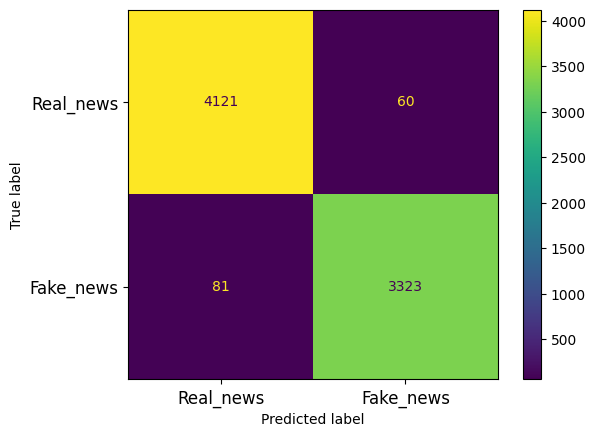

In [27]:
cm = metrics.confusion_matrix(y_val, y_val_pred, labels = lr_pipeline.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Real_news','Fake_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.2 Method_1 Exp_2 Random Forest Classifier

In [28]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [29]:
# 1. Create the full pipeline by chaining the preprocessor and the classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 2. Train the entire pipeline on the training data
rf_pipeline.fit(X_train, y_train)

# 3. Evaluate the model
# (No need for cross-validation on the training set for this example, we'll use the validation set)
y_val_pred = rf_pipeline.predict(X_val)

In [30]:
train_accuracy = rf_pipeline.score(X_train, y_train) # Get accuracy on the training set
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
val_recall = metrics.recall_score(y_val, y_val_pred)
val_precision = metrics.precision_score(y_val, y_val_pred)
val_f1 = metrics.f1_score(y_val, y_val_pred)

In [31]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

Train Accuracy: 1.0000
Validation Accuracy: 0.9721
Validation F1-Score: 0.9685


In [32]:
# Update your results table
parameters = dict(Exp='2_Hybrid', Model_Name='Random Forest (Pipeline)', 
                  Features='Text+Meta', Scale='StandardScaler', 
                  Vectorizer='CountVectorizer', Train_Accuracy=round(train_accuracy,3),
                  Val_Accuracy=round(val_accuracy,3), Val_Recall=round(val_recall,3), 
                  Val_Precision=round(val_precision,3), Val_F1=round(val_f1,3))

hyperparameter_table[-1].update(parameters)

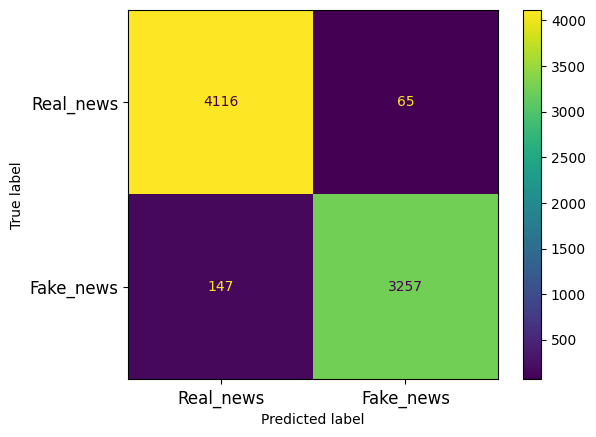

In [33]:
cm = metrics.confusion_matrix(y_val, y_val_pred, labels = rf_pipeline.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Real_news','Fake_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.3 Method_1 Exp_3 Gradient Boost Classifier

In [34]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [35]:
# 1. Create the full pipeline by chaining the preprocessor and the classifier
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# 2. Train the entire pipeline on the training data
gb_pipeline.fit(X_train, y_train)

# 3. Evaluate the model
# (No need for cross-validation on the training set for this example, we'll use the validation set)
y_val_pred = gb_pipeline.predict(X_val)

In [36]:
train_accuracy = gb_pipeline.score(X_train, y_train) # Get accuracy on the training set
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
val_recall = metrics.recall_score(y_val, y_val_pred)
val_precision = metrics.precision_score(y_val, y_val_pred)
val_f1 = metrics.f1_score(y_val, y_val_pred)

In [37]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

Train Accuracy: 0.9761
Validation Accuracy: 0.9711
Validation F1-Score: 0.9675


In [38]:
# Update your results table
parameters = dict(Exp='3_Hybrid', Model_Name='Gradient Boost (Pipeline)', 
                  Features='Text+Meta', Scale='StandardScaler', 
                  Vectorizer='CountVectorizer', Train_Accuracy=round(train_accuracy,3),
                  Val_Accuracy=round(val_accuracy,3), Val_Recall=round(val_recall,3), 
                  Val_Precision=round(val_precision,3), Val_F1=round(val_f1,3))

hyperparameter_table[-1].update(parameters)

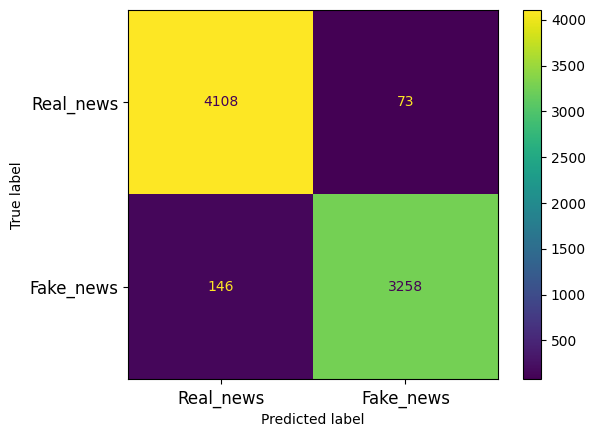

In [39]:
cm = metrics.confusion_matrix(y_val, y_val_pred, labels = gb_pipeline.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Real_news','Fake_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.4 Method_1 Exp_4 XGBoost Classifier

In [40]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [41]:
# 1. Create the full pipeline by chaining the preprocessor and the classifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# 2. Train the entire pipeline on the training data
xgb_pipeline.fit(X_train, y_train)

# 3. Evaluate the model
# (No need for cross-validation on the training set for this example, we'll use the validation set)
y_val_pred = xgb_pipeline.predict(X_val)

In [42]:
train_accuracy = xgb_pipeline.score(X_train, y_train) # Get accuracy on the training set
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
val_recall = metrics.recall_score(y_val, y_val_pred)
val_precision = metrics.precision_score(y_val, y_val_pred)
val_f1 = metrics.f1_score(y_val, y_val_pred)

In [43]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

Train Accuracy: 0.9988
Validation Accuracy: 0.9872
Validation F1-Score: 0.9857


In [44]:
# Update your results table
parameters = dict(Exp='4_Hybrid', Model_Name='XGboost (Pipeline)', 
                  Features='Text+Meta', Scale='StandardScaler', 
                  Vectorizer='CountVectorizer', Train_Accuracy=round(train_accuracy,3),
                  Val_Accuracy=round(val_accuracy,3), Val_Recall=round(val_recall,3), 
                  Val_Precision=round(val_precision,3), Val_F1=round(val_f1,3))

hyperparameter_table[-1].update(parameters)

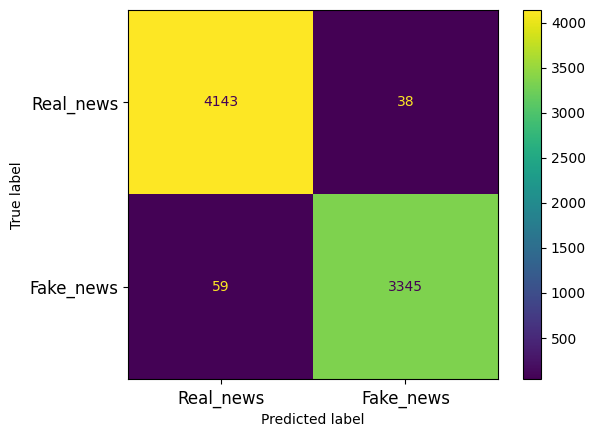

In [45]:
cm = metrics.confusion_matrix(y_val, y_val_pred, labels = xgb_pipeline.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Real_news','Fake_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [46]:
pd.DataFrame(hyperparameter_table)

,Exp,Model_Name,Features,Scale,Vectorizer,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Val_F1
0,1_Hybrid,Logistic Regression (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.999,0.981,0.976,0.982,0.979
1,2_Hybrid,Random Forest (Pipeline),Text+Meta,StandardScaler,CountVectorizer,1.000,0.972,0.957,0.980,0.968
2,3_Hybrid,Gradient Boost (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.976,0.971,0.957,0.978,0.967
3,4_Hybrid,XGboost (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.999,0.987,0.983,0.989,0.986


## 3.3 Performance Test
### 3.3.1 Data Preparation

**Get real news from reuters, cnn and npr.**     
**Get fake news from breitbart and thegatewaypundit.**    
**Totally 25 news**

In [47]:
test = pd.read_csv('../Data/test_set_Feb29_2024.csv', parse_dates=['date'])
test

,title,text,label,source,url,date
0,Exclusive: Former Biden Aide Paid Fani Willis’...,The money flow is significant because sources ...,fake_news,breitbart,https://www.breitbart.com/politics/2024/02/29/...,2024-02-29
1,Judges in Trump-related cases face unprecedent...,U.S.District Judge Royce Lamberth has been thr...,real_news,reuters,https://www.reuters.com/investigates/special-r...,2024-02-29
2,Meet the Experienced Democrat Operative the Bi...,The Biden regime’s collusion with corrupt Fult...,fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/meet-...,2024-02-26
3,Biden pressures Trump to unblock migrant plan ...,"U.S. President Joe Biden and Donald Trump, his...",real_news,reuters,https://www.reuters.com/world/us/biden-trump-m...,2024-02-29
4,Biden and Trump’s dueling border visits will e...,Two presidents will visit the southern US bord...,real_news,cnn,https://www.cnn.com/2024/02/29/politics/border...,2024-02-29
5,WOW! Biden’s Stiff Gait as He Shuffles Along D...,"Joe Biden arrived in Brownsville, Texas on Thu...",fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/wow-b...,2024-02-29
6,Biden has eight months to fix his Michigan pro...,If the Democratic voters of Michigan – and a h...,real_news,cnn,https://www.cnn.com/2024/02/28/politics/biden-...,2024-02-28
7,Some Democrats turn toward Trump in Texas bord...,"Asalia Casares, 52, is a lifelong Democrat who...",real_news,reuters,https://www.reuters.com/world/us/some-democrat...,2024-02-29
8,WAYNE ROOT: “Do You Believe in Miracles?” Some...,“Do you believe in miracles?” Remember those w...,fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/wayne...,2024-02-29
9,Trump says he cannot get fair trial this year ...,Donald Trump's lawyers told a U.S. judge on Th...,real_news,reuters,https://www.reuters.com/world/us/trump-asks-de...,2024-02-29


In [48]:
test['char_count_text'] = test['text'].str.len()
test['word_count_text'] = test['text'].str.split().str.len()
test['avg_word_length_text'] = test['char_count_text']/test['word_count_text']

test['char_count_title'] = test['title'].str.len()
test['word_count_title'] = test['title'].str.split().str.len()
test['avg_word_length_title'] = test['char_count_title']/test['word_count_title']

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.weekday

In [49]:
test['election_day'] = pd.to_datetime("2024-11-05")
test['days_to_election'] = (test['date'] - test['election_day']).dt.days

In [50]:
test['month'] = test['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',\
                                  7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})
test['day_of_week'] = test['day_of_week'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',\
                                               5:'Saturday', 6:'Sunday'})
test['label'] = test['label'].map({"real_news":0, "fake_news":1})

### 3.3.2 Test_1 

In [51]:
X_test = test[['text', 'char_count_text', 'word_count_text', 'avg_word_length_text', 
               'char_count_title', 'word_count_title', 'avg_word_length_title', 
               'year', 'month', 'day', 'day_of_week', 'days_to_election']]
y_test = test.label

In [52]:
y_test_pred = xgb_pipeline.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred)
test_precision = metrics.precision_score(y_test, y_test_pred)
test_f1 = metrics.f1_score(y_test, y_test_pred)

In [53]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set recall score is {round(test_recall,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set f1 score is {round(test_f1,3)}")

The test set accuracy is 0.84
The test set recall score is 0.917
The test set precision score is 0.786
The test set f1 score is 0.846


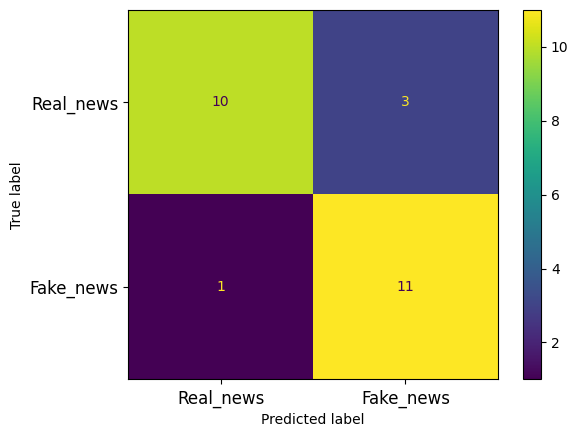

In [54]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = xgb_pipeline.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Real_news','Fake_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Real_news','Fake_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [55]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3),\
             Test_F1=round(test_f1,3))

hyperparameter_table[3].update(result)

In [56]:
pd.DataFrame(hyperparameter_table)

,Exp,Model_Name,Features,Scale,Vectorizer,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Val_F1,Test_Accuracy,Test_Recall,Test_Precision,Test_F1
0,1_Hybrid,Logistic Regression (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.999,0.981,0.976,0.982,0.979,NaN,NaN,NaN,NaN
1,2_Hybrid,Random Forest (Pipeline),Text+Meta,StandardScaler,CountVectorizer,1.000,0.972,0.957,0.980,0.968,NaN,NaN,NaN,NaN
2,3_Hybrid,Gradient Boost (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.976,0.971,0.957,0.978,0.967,NaN,NaN,NaN,NaN
3,4_Hybrid,XGboost (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.999,0.987,0.983,0.989,0.986,0.84,0.917,0.786,0.846


In [57]:
final_xgb_classifier = xgb_pipeline.named_steps['classifier']
preprocessor = xgb_pipeline.named_steps['preprocessor']
# For XGBoost, the attribute is .feature_importances_
importances = final_xgb_classifier.feature_importances_

# The feature names come from the preprocessor, same as before
feature_names = preprocessor.get_feature_names_out()


# --- Step 3: Create, filter, and sort the DataFrame ---
all_features_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Filter to keep only the word features from the CountVectorizer
word_features_df = all_features_df[all_features_df['feature'].str.startswith('count__')].copy()

# Clean up the feature names by removing the "count__" prefix
word_features_df['feature'] = word_features_df['feature'].str.removeprefix('count__')

# Sort the DataFrame by importance in DESCENDING order
word_features_df = word_features_df.sort_values(by='importance', ascending=False)


# --- Step 4: Display the results ---
print("--- Top 20 Most Important Words for the XGBoost Model ---")
print("(Note: Importance score does not indicate direction, only impact)")
print(word_features_df.head(20))

--- Top 20 Most Important Words for the XGBoost Model ---
(Note: Importance score does not indicate direction, only impact)
                feature  importance
40032               gop    0.020414
70978               pic    0.020259
50402              just    0.019156
80709              said    0.014723
55303              like    0.014556
3425               21st    0.012039
44752             https    0.010303
34424              fact    0.009754
48283               isn    0.009525
12858            barack    0.008953
22444               com    0.008916
93357             trade    0.008432
28294              didn    0.008086
76173   realdonaldtrump    0.007804
60861          ministry    0.007387
60854          minister    0.007331
7054           actually    0.007263
99595         wednesday    0.006978
100584             wire    0.006887
94496           tuesday    0.006676


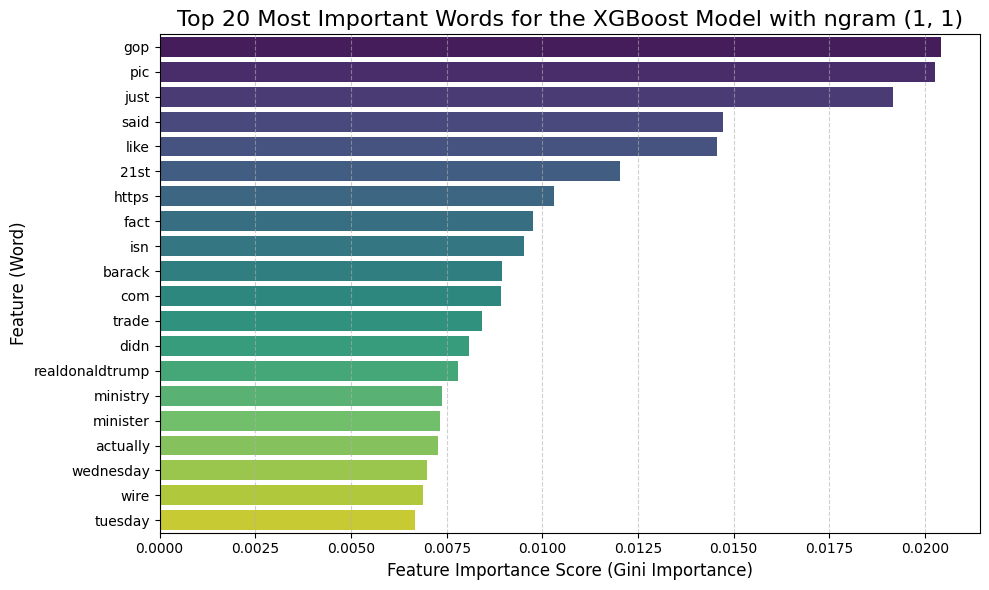

In [58]:
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability

# Create the horizontal bar plot using seaborn
sns.barplot(
    x='importance', 
    y='feature', 
    data=word_features_df.head(20), 
    palette='viridis' # You can choose other palettes like 'plasma', 'mako', etc.
)

# Add a title and labels for clarity
plt.title('Top 20 Most Important Words for the XGBoost Model with ngram (1, 1)', fontsize=16)
plt.xlabel('Feature Importance Score (Gini Importance)', fontsize=12)
plt.ylabel('Feature (Word)', fontsize=12)

# Optional: Add a grid for easier reading of values
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Ensure the layout is tight
plt.tight_layout()

# Display the plot
plt.show()


### 3.3.3 Test_2 

In [59]:
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [60]:
tuned_text_transformer = CountVectorizer(
stop_words='english',
max_features=2000, # Increased vocabulary size
ngram_range=(1, 3), # Include bigrams
max_df=0.80, # Ignore terms that are too frequent
min_df=5 # Ignore terms that are too rare
)

In [61]:
preprocessor_tuned = ColumnTransformer(
transformers=[
('num', numeric_transformer, numeric_features),
('cat', categorical_transformer, categorical_features),
('count', tuned_text_transformer, text_feature) # Use the new transformer
],
remainder='drop'
)

In [62]:
xgb_pipeline_tuned = Pipeline(steps=[
('preprocessor', preprocessor_tuned), # Use the new preprocessor here!
('classifier', XGBClassifier(random_state=42))
])

xgb_pipeline_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['char_count_text',
                                                   'word_count_text',
                                                   'avg_word_length_text',
                                                   'char_count_title',
                                                   'word_count_title',
                                                   'avg_word_length_title',
                                                   'year', 'day',
                                                   'days_to_election']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day_of_week']),
                                                 ('count',
                                                  CountVectorizer(max_df=0.8...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [63]:
train_accuracy = xgb_pipeline_tuned.score(X_train, y_train)
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
val_recall = metrics.recall_score(y_val, y_val_pred)
val_precision = metrics.precision_score(y_val, y_val_pred)
val_f1 = metrics.f1_score(y_val, y_val_pred)


y_test_pred = xgb_pipeline.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred)
test_precision = metrics.precision_score(y_test, y_test_pred)
test_f1 = metrics.f1_score(y_test, y_test_pred)

In [64]:
vectorizer_params = "max_features=2000, ngram_range=(1,3), max_df=0.8, min_df=5"

parameters = dict(Exp='5_Hybrid_Tuned', Model_Name='XGboost (Pipeline)',
Features='Text+Meta', Scale='StandardScaler',
Vectorizer='CountVectorizer', Vectorizer_Params=vectorizer_params, # Add new column
Train_Accuracy=round(train_accuracy,3),
Val_Accuracy=round(val_accuracy,3), Val_Recall=round(val_recall,3),
Val_Precision=round(val_precision,3), Val_F1=round(val_f1,3),
Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3),
Test_Precision=round(test_precision,3), Test_F1=round(test_f1,3))

hyperparameter_table[-1].update(parameters)

In [65]:
pd.DataFrame(hyperparameter_table)

,Exp,Model_Name,Features,Scale,Vectorizer,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Val_F1,Test_Accuracy,Test_Recall,Test_Precision,Test_F1,Vectorizer_Params
0,1_Hybrid,Logistic Regression (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.999,0.981,0.976,0.982,0.979,NaN,NaN,NaN,NaN,NaN
1,2_Hybrid,Random Forest (Pipeline),Text+Meta,StandardScaler,CountVectorizer,1.000,0.972,0.957,0.980,0.968,NaN,NaN,NaN,NaN,NaN
2,3_Hybrid,Gradient Boost (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.976,0.971,0.957,0.978,0.967,NaN,NaN,NaN,NaN,NaN
3,4_Hybrid,XGboost (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.999,0.987,0.983,0.989,0.986,0.84,0.917,0.786,0.846,NaN
4,5_Hybrid_Tuned,XGboost (Pipeline),Text+Meta,StandardScaler,CountVectorizer,0.999,0.987,0.983,0.989,0.986,0.84,0.917,0.786,0.846,"max_features=2000, ngram_range=(1,3), max_df=0..."


In [66]:
final_xgb_classifier = xgb_pipeline_tuned.named_steps['classifier']
preprocessor = xgb_pipeline_tuned.named_steps['preprocessor']

# For XGBoost, the attribute is .feature_importances_
importances = final_xgb_classifier.feature_importances_

# The feature names come from the preprocessor, same as before
feature_names = preprocessor.get_feature_names_out()


# --- Step 3: Create, filter, and sort the DataFrame ---
all_features_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Filter to keep only the word features from the CountVectorizer
word_features_df = all_features_df[all_features_df['feature'].str.startswith('count__')].copy()

# Clean up the feature names by removing the "count__" prefix
word_features_df['feature'] = word_features_df['feature'].str.removeprefix('count__')

# Sort the DataFrame by importance in DESCENDING order
word_features_df = word_features_df.sort_values(by='importance', ascending=False)


# --- Step 4: Display the results ---
print("--- Top 20 Most Important Words for the XGBoost Model ---")
print("(Note: Importance score does not indicate direction, only impact)")
print(word_features_df.head(20))

--- Top 20 Most Important Words for the XGBoost Model ---
(Note: Importance score does not indicate direction, only impact)
                           feature  importance
1905                   twitter com    0.022453
1377        president donald trump    0.017532
785                            gop    0.015628
1374              president barack    0.015523
986                           just    0.014694
1608                          said    0.013330
1056                          like    0.012838
1904                       twitter    0.012531
1317                   pic twitter    0.012348
869                          https    0.011237
1316                           pic    0.010075
405                            com    0.010057
1376              president donald    0.009604
1539               representatives    0.009023
592   donald trump realdonaldtrump    0.008808
235                         barack    0.008495
100                       actually    0.008428
1224                          

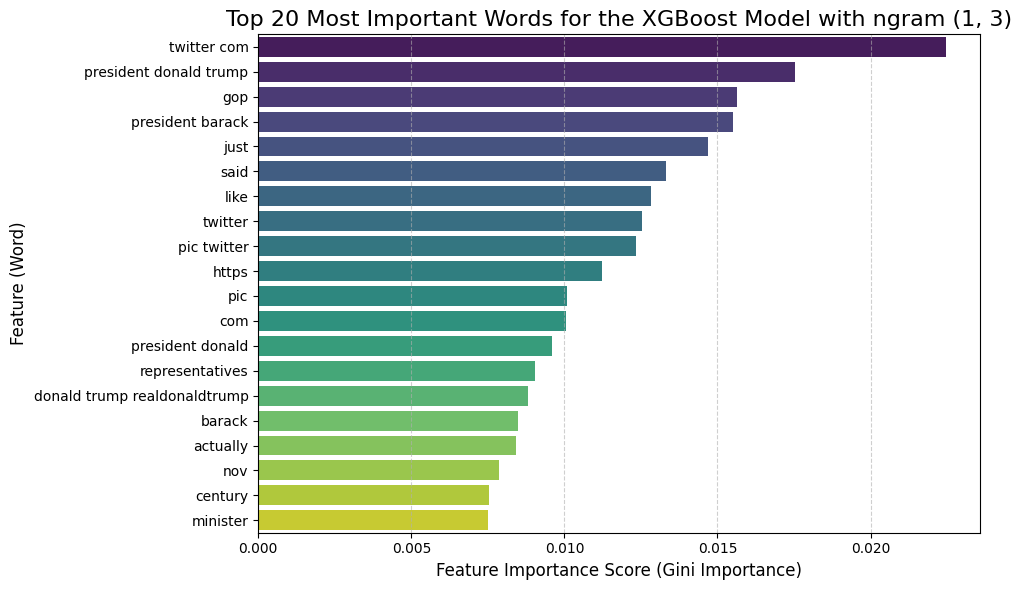

In [67]:
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability

# Create the horizontal bar plot using seaborn
sns.barplot(
    x='importance', 
    y='feature', 
    data=word_features_df.head(20), 
    palette='viridis' # You can choose other palettes like 'plasma', 'mako', etc.
)

# Add a title and labels for clarity
plt.title('Top 20 Most Important Words for the XGBoost Model with ngram (1, 3)', fontsize=16)
plt.xlabel('Feature Importance Score (Gini Importance)', fontsize=12)
plt.ylabel('Feature (Word)', fontsize=12)

# Optional: Add a grid for easier reading of values
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Ensure the layout is tight
plt.tight_layout()

# Display the plot
plt.show()
